#### CIE-Project B || Group - 7

#### Imports

In [447]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, CuDNNLSTM
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
# from keras_tuner.tuners import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
%matplotlib widget

##### Get the root directory and change to it

In [448]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Folder Variables Assignment

In [449]:
# Names of the folders
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse training and validation-augmented data

In [450]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
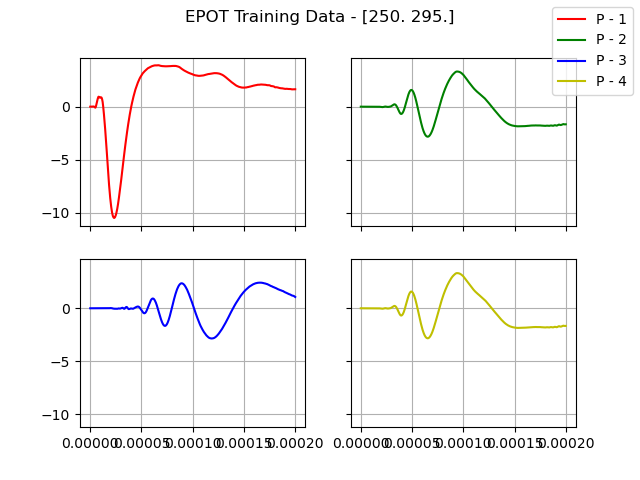

In [451]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 6

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

##### Parse, Cut, Normalize, and Resample the experimental data

In [452]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
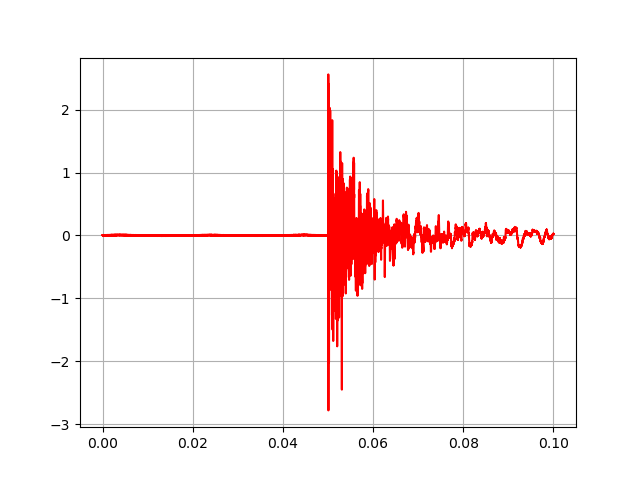

In [453]:
plt.close()
l = 5
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()

In [454]:
ex_cut_data=[]
for i in range(0,len(ex_data)):

    data = ex_data[i]
    start_time = 0.04996
    end_time = 0.05016

    start=np.where(data==(start_time))
    end = np.where(data==(end_time))
    
    d = np.zeros(((200),5))

    d[:,0]=ex_data[i][start[0][0]:start[0][0]+200,0]
    d[:,1]=ex_data[i][start[0][0]:start[0][0]+200,1]
    d[:,2]=ex_data[i][start[0][0]:start[0][0]+200,2]
    d[:,3]=ex_data[i][start[0][0]:start[0][0]+200,4]
    d[:,4]=ex_data[i][start[0][0]:start[0][0]+200,3]

    # append data to a numpy array
    ex_cut_data.append(d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
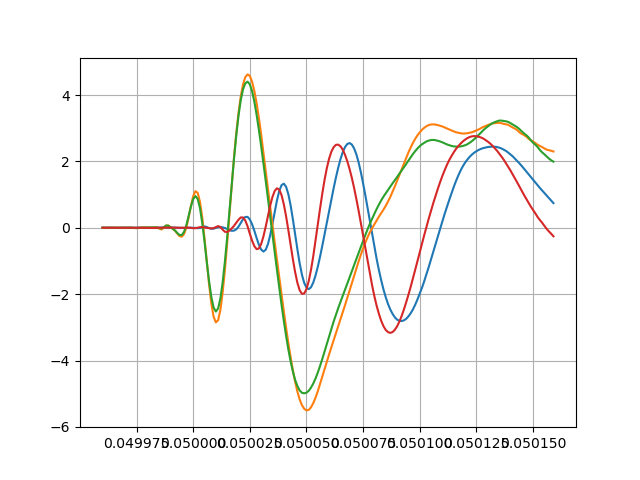

In [455]:
plt.close()
l = 4
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,1], label='P - 1')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,2], label='P - 2')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,3], label='P - 3')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,4], label='P - 4')
plt.show()

Normalize and Resample experimental data

In [456]:
# create variables for normalized data
ex_norm = np.zeros_like(np.asarray(ex_cut_data))

for i in range (0, len(ex_cut_data)):
    for j in range (1, 5):
        ex_norm[i][:,j] = minmax_scale(ex_cut_data[i][:,j])

In [457]:
ex_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_norm)):
    ex_resample.append(pd.DataFrame(ex_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_resample[i] = ex_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_resample)):
    ex_resample[i] = resample(ex_resample[i], size)

np.asarray(ex_resample).shape

(42, 100, 4)

##### Parse, Cut, Normalize, and Resample the experimental validation data

In [458]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)


ex_val_trails = np.asarray(ex_val_labels)[:,2]
ex_val_labels = np.delete(ex_val_labels, 2, 1)

In [459]:
ex_val_cut_data=[]
for i in range(0,len(ex_val_data)):
    data=ex_data[i][:,0]
    
    start_time = 0.04996
    end_time = 0.05016
    start=np.where(data==(start_time))
    end = np.where(data==(end_time))
    
    d = np.zeros(((start[0][0]+200-start[0][0]),5))

    d[:,0]=ex_val_data[i][start[0][0]:start[0][0]+200,0]
    d[:,1]=ex_val_data[i][start[0][0]:start[0][0]+200,1]
    d[:,2]=ex_val_data[i][start[0][0]:start[0][0]+200,2]
    d[:,3]=ex_val_data[i][start[0][0]:start[0][0]+200,4]
    d[:,4]=ex_val_data[i][start[0][0]:start[0][0]+200,3]
    
    ex_val_cut_data.append(d)

Normalize and Resample experimental validation data

In [460]:
# create variables for normalized data
ex_val_norm = np.zeros_like(np.asarray(ex_val_cut_data)); ex_val_norm_labels = np.zeros_like(np.asarray(ex_val_cut_data))

for i in range (0, len(ex_val_cut_data)):
    for j in range (1, 5):
        ex_val_norm[i][:,j] = minmax_scale(ex_val_cut_data[i][:,j])

scalar = MinMaxScaler()
ex_val_norm_labels = scalar.fit_transform(ex_val_labels)

In [461]:
ex_val_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_val_norm)):
    ex_val_resample.append(pd.DataFrame(ex_val_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_val_resample[i] = ex_val_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_val_resample)):
    ex_val_resample[i] = resample(ex_val_resample[i], size)

np.asarray(ex_val_resample).shape

(24, 100, 4)

#### Augmentation

##### Variable initialization

In [462]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [463]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [464]:
for i in range (0, len(training_bl)):
    training_bl[i][:,0] = training_tl[i][:,0]
    training_bl[i][:,1] = training_tl[i][:,3]
    training_bl[i][:,2] = training_tl[i][:,2]
    training_bl[i][:,3] = training_tl[i][:,1]
    training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [465]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [466]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [467]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
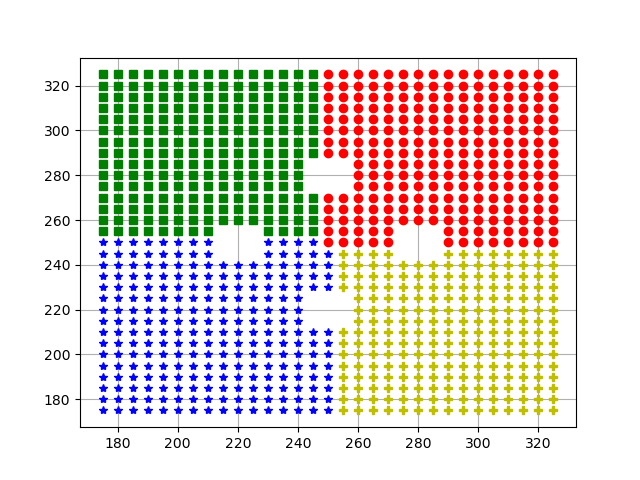

In [468]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')            

plt.show()

#### Concatenate, Normalize, Resample Training Data

##### Concatenate

In [469]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
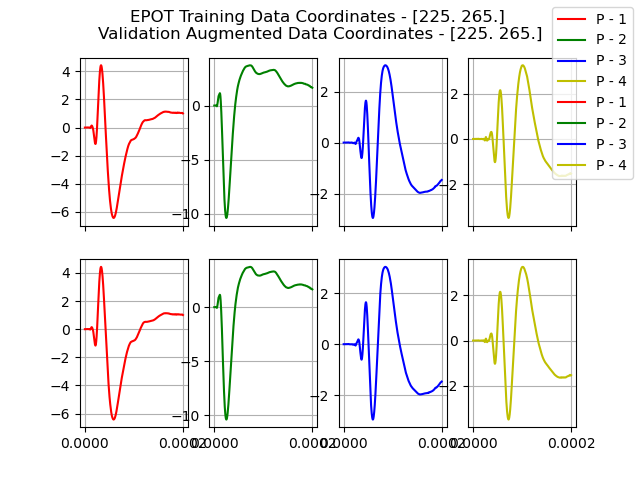

In [470]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 1 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [471]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0.     , 0.     , 0.     , ..., 0.00011, 0.00012, 0.00012])

##### -- Check -- for outliers

In [472]:
'''
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(len(training)):
    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')
    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')
    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')
    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')

plt.show()
'''

"\nplt.close()\nfig, axs = plt.subplots(2, 2, sharex=True, sharey=True)\n\nfor i in range(len(training)):\n    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')\n    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')\n    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')\n    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')\n\nplt.show()\n"

In [473]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(training)):
    xi = training_labels[i][0]
    x.append(xi)
    yi = training_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(training[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(training)):\n    xi = training_labels[i][0]\n    x.append(xi)\n    yi = training_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(training[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

Experimental Validation

In [474]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(ex_val_data)):
    xi = ex_val_labels[i][0]
    x.append(xi)
    yi = ex_val_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(ex_val_data)):\n    xi = ex_val_labels[i][0]\n    x.append(xi)\n    yi = ex_val_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

##### Normalize Training Data

In [475]:
# create variables for normalized data
train_norm = np.zeros_like(np.asarray(training)); train_norm_labels = np.zeros_like(np.asarray(training_labels))

for i in range (0, len(training)):
    for j in range (1, 5):
        train_norm[i][:,j] = minmax_scale(training[i][:,j])

scalar = MinMaxScaler()
train_norm_labels = scalar.fit_transform(training_labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
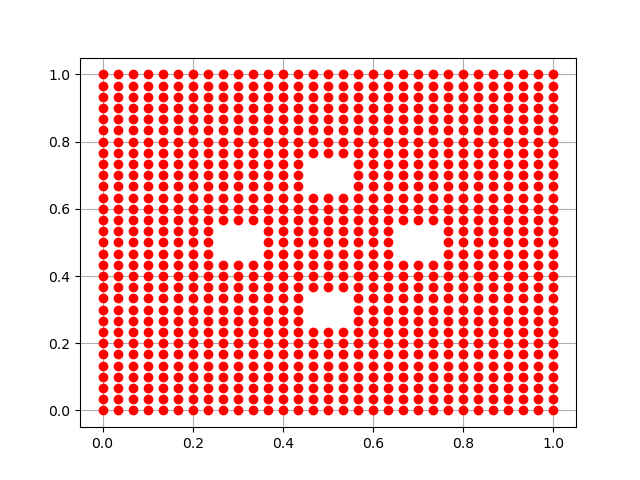

In [476]:
plt.close()
plt.plot(train_norm_labels[:,0], train_norm_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend(loc='lower center', bbox_to_anchor=(1, -0.5))
plt.show()

##### Resample Training Data

In [477]:
train_resample = []

# create a dataframe from the normalized data
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(train_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape

(925, 100, 4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
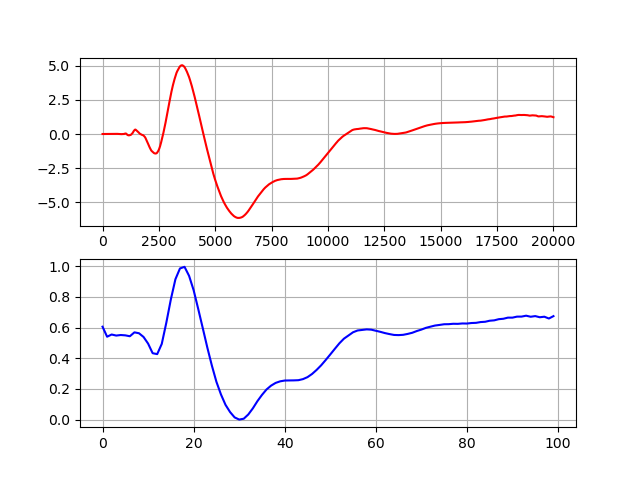

In [478]:
plt.close()
fig, axs = plt.subplots(2, 1)

axs[0].plot(training[0][:,1], c = 'r')
axs[1].plot(train_resample[0][:,1], c = 'b')

plt.show()

#### Compare Experimental, Experimental-Validation and Training Data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
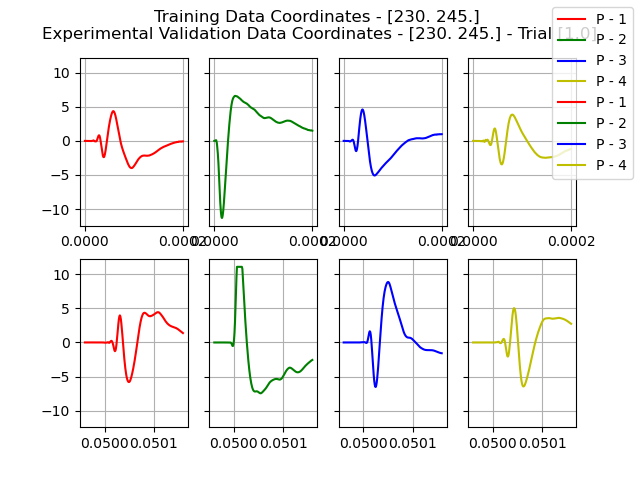

In [479]:
plt.close()
fig, axs = plt.subplots(2, 4, sharey=True)

ex_val_c = 1 # Given validation folder has 24 data points. so use - (0, 1, .... , 23)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == ex_val_labels[ex_val_c][0]) and (training_labels[i][1] == ex_val_labels[ex_val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'Training Data Coordinates - {training_labels[x[0]]} \nExperimental Validation Data Coordinates - {ex_val_labels[ex_val_c]} - Trial [{ex_val_trails[l]}]')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
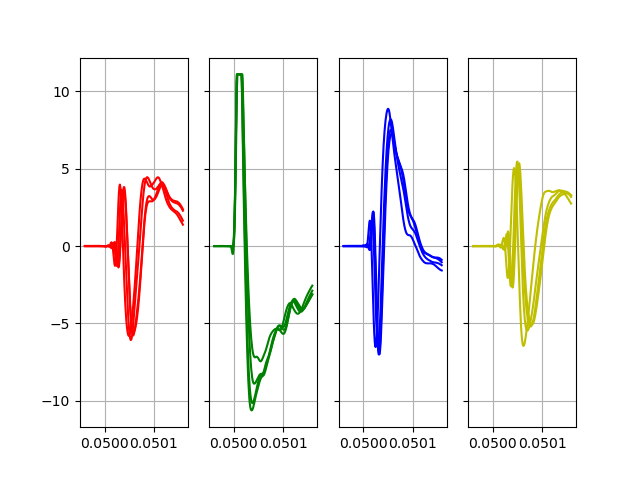

In [480]:
plt.close()
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
for i in range(4):
    axs[0].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,1], c = 'r', label = 'Exp Val Data - P-1')
    axs[1].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,2], c = 'g', label = 'Exp Val Data - P-2')
    axs[2].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,3], c = 'b', label = 'Exp Val Data - P-3')
    axs[3].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,4], c = 'y', label = 'Exp Val Data - P-4')

plt.show()

#### Export data to pickle

In [481]:

# with open('train_resample.pickle', 'wb') as f:
#     pickle.dump(train_resample, f)
# with open('train_norm_labels.pickle', 'wb') as f:
#     pickle.dump(train_norm_labels, f)

# with open('training_labels.pickle', 'wb') as f:
#     pickle.dump(training_labels, f)

# with open('exp_validation_data.pickle', 'wb') as f:
#     pickle.dump(ex_val_data, f)
# with open('exp_validation_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_labels, f)

# with open('exp_val_resample.pickle', 'wb') as f:
#     pickle.dump(ex_val_resample, f)
# with open('exp_val_norm_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_norm_labels, f)

#### AI Model

##### Split the data into training and testing sets

In [482]:
# Extract the data from the pickle files

'''
with open('train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)
with open('train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)
'''

X = np.asarray(train_resample)
y = np.asarray(train_norm_labels)

# create split data from the normalized data
size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {len(x_train)} length of labels - {len(y_train)} \nLength of test data - {len(x_test)} and length of labels - {len(y_test)}')

Length of training data - 740 length of labels - 740 
Length of test data - 185 and length of labels - 185


##### TensorBoard

In [483]:
%tensorboard --logdir=logs/

UsageError: Line magic function `%tensorboard` not found.


##### Model Training and Tuning

In [484]:
'''
log_files = f'DNN_log.{int(time.time())}'
tuner_logs= f'tunelog/DNN_tuner_log.{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{log_files}', 
                          histogram_freq=1, 
                          write_graph=True,
                          write_grads=True)


def dnnModel(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(100,4)))
    model.add(Dense(units=hp.Int('layer_1_nodes', 
                    min_value=32, max_value=512, step=32), 
                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))
    
    for i in range(hp.Int('n_layers', min_value=0, max_value=4, step=1)):
        model.add(Dense(units=hp.Int(f'layer_{i+1}_nodes', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))
    
    model.add(Dense(units=2, activation=hp.Choice("activation_out", ['sigmoid', 'linear']))) # output layer

    model.summary()

    # Compile model
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)

    model.compile(loss = hp.Choice('loss', ['mae']),
                optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop']), 
                metrics=['Accuracy'])
    
    return model

# Hyperparameter tuning
tuner = RandomSearch(dnnModel,
                    objective='val_Accuracy',
                    max_trials=50,
                    executions_per_trial=2,
                    directory=tuner_logs,
                    project_name='DNN_tuning')

tuner.search(x=x_train,
            y=y_train,
            epochs=60,
            batch_size=32,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard])
            '''

'\nlog_files = f\'DNN_log.{int(time.time())}\'\ntuner_logs= f\'tunelog/DNN_tuner_log.{int(time.time())}\'\n\ntensorboard = TensorBoard(log_dir=f\'logs/{log_files}\', \n                          histogram_freq=1, \n                          write_graph=True,\n                          write_grads=True)\n\n\ndef dnnModel(hp):\n    model = Sequential()\n    model.add(Flatten(input_shape=(100,4)))\n    model.add(Dense(units=hp.Int(\'layer_1_nodes\', \n                    min_value=32, max_value=512, step=32), \n                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))\n    \n    for i in range(hp.Int(\'n_layers\', min_value=0, max_value=4, step=1)):\n        model.add(Dense(units=hp.Int(f\'layer_{i+1}_nodes\', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))\n    \n    model.add(Dense(units=2, activation=hp.Choice("activation_out", [\'sigmoid\', \'linear\']))) # output layer\n\n    model.summary()\

In [485]:
# bestModels = tuner.get_best_models(num_models=2)

In [486]:
# Save the keras model
# model.save(f'model/complete_tunedModel_95perAcc.{int(time.time())}.h5')

#### DNN Model

In [487]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))

model.add(Dense(units=768, activation='relu'))

model.add(Dense(units=352, activation='relu'))

model.add(Dense(units=2, activation='linear'))

model.summary()

# Compile model
opt = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 400)               0         
                                                                 
 dense_28 (Dense)            (None, 768)               307968    
                                                                 
 dense_29 (Dense)            (None, 352)               270688    
                                                                 
 dense_30 (Dense)            (None, 2)                 706       
                                                                 
Total params: 579,362
Trainable params: 579,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


D:\lectures\sem3\cie\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 0s 10ms/step - loss: 0.3146 - Accuracy: 0.4865 - val_loss: 0.2585 - val_Accuracy: 0.5892
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.2453 - Accuracy: 0.6027 - val_loss: 0.2514 - val_Accuracy: 0.6216
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.2135 - Accuracy: 0.6919 - val_loss: 0.2177 - val_Accuracy: 0.7081
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.1849 - Accuracy: 0.7797 - val_loss: 0.1911 - val_Accuracy: 0.7405
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1513 - Accuracy: 0.8338 - val_loss: 0.1593 - val_Accuracy: 0.8054
Epoch 6/50
24/24 [==============================] - 0s 7ms/step - loss: 0.1320 - Accuracy: 0.8324 - val_loss: 0.1690 - val_Accuracy: 0.8378
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.1162 - Accuracy: 0.8743 - val_loss: 0.1298 - val_Accuracy: 0.7946
Epoch 8/50
24/24 [============

In [488]:
# model.save(f'model/val_acc_94perAcc.{int(time.time())}.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
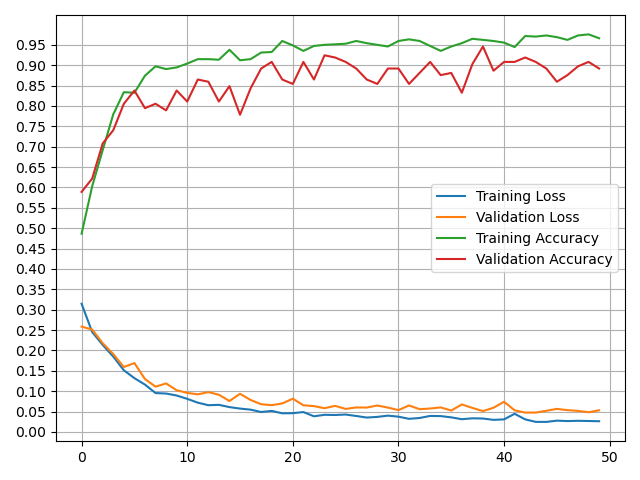

In [489]:
plt.close()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### CNN Model

In [490]:
cnn_model = Sequential()
# create a CNN cnn_model
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,4)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
# cnn_model.add(Dense(units=300, activation='linear'))
cnn_model.add(Dense(units=2, activation='linear'))
cnn_model.summary()


# Compile cnn_model
opt = tf.keras.optimizers.Adam(lr=0.0001)

cnn_model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the cnn_model
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 98, 32)            416       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 49, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 47, 32)            3104      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 23, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 21, 32)            3104      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 10, 32)         

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
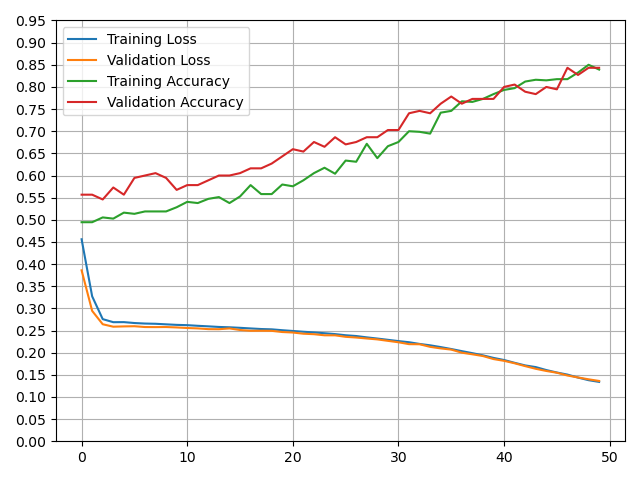

In [491]:
plt.close()
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_history.history['Accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### SVR Model

In [492]:
# with open('train_resample.pickle', 'rb') as f:
#     train_resample = pickle.load(f)

# with open('train_norm_labels.pickle', 'rb') as f:
#     train_norm_labels = pickle.load(f)

# with open('training_labels.pickle', 'rb') as f:
#     training_labels = pickle.load(f)

# X = train_resample
# y = training_labels

# scalar = MinMaxScaler()
# y_norm = scalar.fit_transform(y)

# print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


In [493]:
x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)

(832, 400) (832, 2)


#### Single SVR wrapped in Multioutput SVR

In [494]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create the SVR regressor
svr = SVR(epsilon=0.2)

# Create the Multioutput Regressor
mor = MultiOutputRegressor(svr)

# Train the regressor
mor = mor.fit(x_train_flat, y_train)

# Generate predictions for testing data
y_pred = mor.predict(x_test_flat)

# Evaluate the regressor
mse_one = mean_squared_error(y_test[:,0], y_pred[:,0])
mse_two = mean_squared_error(y_test[:,1], y_pred[:,1])
print(f'MSE for first regressor: {mse_one} - second regressor: {mse_two}')
mae_one = mean_absolute_error(y_test[:,0], y_pred[:,0])
mae_two = mean_absolute_error(y_test[:,1], y_pred[:,1])
print(f'MAE for first regressor: {mae_one} - second regressor: {mae_two}')

MSE for first regressor: 0.030992847473073484 - second regressor: 0.03512113163615564
MAE for first regressor: 0.159627551589965 - second regressor: 0.17683592983922258


In [495]:
# x_train_flat = []
# for i in range(len(x_train)):    
#     x_dummy = np.asarray(x_train[i]).flatten()
#     x_train_flat.append(x_dummy)
    
# x_train_flat = np.asarray(x_train_flat)

# x_test_flat = []
# for i in range(len(x_test)):    
#     x_dummy = np.asarray(x_test[i]).flatten()
#     x_test_flat.append(x_dummy)
    
# x_test_flat = np.asarray(x_test_flat)

# print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)

In [496]:
# regr_multirf = MultiOutputRegressor(svm.SVR())
# regr_multirf.fit(x_train_flat, y_train)

In [497]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline

# pipe_svr = (Pipeline([('scl', StandardScaler()),
#                   ('reg', SVR())]))

# grid_param_svr = {
#     'reg__C': [0.01,0.1,1,10],
#     'reg__epsilon': [0.1,0.2,0.3],
#     'degree': [2,3,4]
# }

# gs_svr = (GridSearchCV(estimator=pipe_svr, 
#                   param_grid=grid_param_svr, 
#                   cv=10,
#                   scoring = 'neg_mean_squared_error',
#                   n_jobs = -1))

# gs_svr = gs_svr.fit(x_train_flat,y_train)

In [498]:
# y_pred = regr_multirf.predict(x_test_flat)
# y_pred = scalar.inverse_transform(y_pred)
# y_test = scalar.inverse_transform(y_test)

In [499]:
y_test-y_pred

array([[-0.29300507,  0.17882823],
       [-0.26269306,  0.10988296],
       [-0.20982132,  0.05677284],
       [ 0.20781081,  0.15032833],
       [-0.12011243,  0.20425089],
       [-0.07616446,  0.22261658],
       [ 0.19870202, -0.08244936],
       [ 0.20176534,  0.0804167 ],
       [-0.2159406 ,  0.2743107 ],
       [-0.17158252, -0.20290468],
       [-0.19219615, -0.20546083],
       [-0.18661314, -0.20428546],
       [-0.19546342, -0.20924651],
       [ 0.10574775, -0.20757693],
       [ 0.12826713,  0.20789838],
       [-0.17780677, -0.17761588],
       [ 0.20276574, -0.00060004],
       [-0.09269802,  0.2289487 ],
       [ 0.2009569 , -0.03723335],
       [-0.21783668,  0.13416232],
       [ 0.12214899, -0.12409061],
       [ 0.08260733, -0.15979113],
       [ 0.19475761,  0.26526879],
       [ 0.15035479, -0.20457466],
       [-0.20304088, -0.1942488 ],
       [ 0.23101931,  0.15638968],
       [ 0.04790582,  0.20446392],
       [-0.20356437, -0.13130475],
       [-0.19207873,

### SVR GitHub

In [500]:
import numpy as np
import sklearn
from sklearn import svm


class MultiSVR(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
  def __init__(self, **kwargs):
    self.__init_kwargs = kwargs

  def fit(self, X, y, **kwargs):
    X = np.array(X)
    y = np.array(y)

    # Get dimension of y
    y_dim = np.ndim(y)
    if(y_dim == 2):
      # Feature dimension
      feature_dim = len(y[0])
      # Create SVRs
      self.svrs   = [svm.SVR(**self.__init_kwargs) for _ in range(feature_dim)]

      # For each SVR
      for curr_feature_dim, svr in enumerate(self.svrs): # (curr=Current)
        # Select y
        selected_y = y[:,curr_feature_dim]
        # Fit
        svr.fit(X, selected_y, **kwargs)
    else:
      raise Exception("Dimension of y must be 2, but found %d" % y_dim)


  def predict(self, X):
    # Init predict list
    preds = []
    # For each SVR
    for curr_feature_dim, svr in enumerate(self.svrs):  # (curr=Current)
      # Predict
      pred = svr.predict(X)
      # Append to preds
      preds.append(pred)

    pred = np.column_stack(tuple(preds))
    return pred


In [501]:
from sklearn import metrics
#  Create SVR
regressor = MultiSVR(kernel='linear')
# Fit
regressor.fit(x_train_flat, y_train)
# Predict
pred_y = regressor.predict(x_test_flat)
# Calc errors
errs = metrics.mean_squared_error(y_test, pred_y)

print('pred_y:', pred_y)
print('errs:', errs)

pred_y: [[0.97226862 0.65420026]
 [0.44702087 0.30839543]
 [0.33029756 0.60244718]
 [0.82589102 0.5090253 ]
 [0.44465761 0.72911926]
 [0.43439211 0.3526924 ]
 [0.6733857  0.32730733]
 [0.65462814 0.44743253]
 [0.87375007 0.37596526]
 [0.40297831 0.26179337]
 [0.85628665 0.92505407]
 [0.40705776 0.61039476]
 [0.35911849 0.25863095]
 [0.61902587 0.27755847]
 [0.67827722 0.61626156]
 [0.24862679 0.26977225]
 [0.71177061 0.42057005]
 [0.34380952 0.62665635]
 [0.85861454 0.33291477]
 [0.28184791 0.72229976]
 [0.55796586 0.47106018]
 [0.5381241  0.56899892]
 [0.47763709 0.08507896]
 [0.54969249 0.59895986]
 [0.43805171 0.4028795 ]
 [0.20684951 0.16258432]
 [0.59700149 0.68099239]
 [0.3731968  0.46124216]
 [0.35838518 0.76655147]
 [0.49858124 0.7744291 ]
 [0.36803738 0.2383818 ]
 [0.73298109 0.39211087]
 [0.43519274 0.59034905]
 [0.41956963 0.21468173]
 [0.58042927 0.69544962]
 [0.37767172 0.40859152]
 [0.48366548 0.51693409]
 [0.32899589 0.76448696]
 [0.25555832 0.34258432]
 [0.72498802 0.27

#### KNN Model

In [502]:
with open('train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)

with open('train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)

with open('training_labels.pickle', 'rb') as f:
    training_labels = pickle.load(f)

with open('exp_val_resample.pickle', 'rb') as f:
    exp_val_resample = pickle.load(f)

with open('exp_val_norm_labels.pickle', 'rb') as f:
    exp_val_labels = pickle.load(f)

X = train_resample
y = training_labels

exp_val_X = exp_val_resample
exp_val_y = exp_val_labels

scalar = MinMaxScaler()
y_norm = scalar.fit_transform(training_labels)

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

FileNotFoundError: [Errno 2] No such file or directory: 'train_resample.pickle'

In [ ]:
x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

exp_val_X_flat = []
for i in range(len(exp_val_X)):
    x_dummy = np.asarray(exp_val_X[i]).flatten()
    exp_val_X_flat.append(x_dummy)

exp_val_X_flat = np.asarray(exp_val_X_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)
print(x_test_flat.shape, y_test.shape)
print(exp_val_X_flat.shape, exp_val_y.shape)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(x_train_flat, y_train)

In [ ]:
y_pred = knn.predict(x_test_flat)

y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test)

y_test-y_pred

In [ ]:
y_pred_exp = knn.predict(exp_val_X_flat)
y_pred_exp = scalar.inverse_transform(y_pred_exp)
exp_val_y = scalar.inverse_transform(exp_val_y)

exp_val_y-y_pred_exp

#### Predict experimental data validation

In [ ]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('model/val_acc_94perAcc.1641231353.h5')
model = tf.keras.models.load_model('model/95perAcc.1640511698.h5')


In [ ]:
y_pred = model.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels
y_pred = scalar.inverse_transform(np.asarray(y_pred))

In [ ]:
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

#### -- Check -- prediction for augmentation validation data

In [ ]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

checking3 = validation_aug[2][:,1:5]
checking3 = minmax_scale(checking3)
checking3 = resample(checking3, 100)

checking4 = validation_aug[3][:,1:5]
checking4 = minmax_scale(checking4)
checking4 = resample(checking4, 100)

c.append(checking1)
c.append(checking2)
c.append(checking3)
c.append(checking4)

'''
plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()
'''

In [ ]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]} \n{validation_aug_labels[2]} \n{validation_aug_labels[3]}')

p = model.predict(np.asarray(c))
p = scalar.inverse_transform(p)
print(p)

error = []
for i in range(0, len(p)):
    a = validation_aug_labels[i][0]-p[i][0]
    b = validation_aug_labels[i][1]-p[i][1]
    e = [a, b]
    error.append(e)

print(f'Difference between the actual and predicted coordinates: \n{np.asarray(error)}')